In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from oggm import utils
import os, copy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import ColorbarBase
from salem.graphics import ExtendedNorm

In [9]:
# dfr = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_allglaciers_stats.h5'))

In [10]:
df = pd.read_hdf('icevol_compiled.hdf')
df_ = pd.read_hdf('icevol_compiled_float32.hdf')

In [16]:
df.loc['RGI60-11.00897'].composite_vol_m3 / df_.loc['RGI60-11.00897'].composite_vol_m3

1.0000000175687678

In [12]:
df.composite_vol_m3.sum()

158165891730176.94

In [15]:
np.abs(df_.composite_vol_m3 / df.composite_vol_m3).mean()

0.9999999998735354

In [39]:
len(dfr), len(df)

(216502, 215535)

In [56]:
df.loc[df['model_4_vol_m3']==0, 'model_4_vol_m3'] = np.NaN 
df.loc[df['model_1_vol_m3']==0, 'model_1_vol_m3'] = np.NaN 

In [97]:
df['rgi_area_km2'] = dfr['Area']
df['composite_vol_km3'] = df['model_4_vol_m3'] * 1e-9

In [98]:
df.composite_vol_km3.sum(), df.rgi_area_km2.sum()

(13196.482703993028, 705437.549)

In [99]:
rho = 900
A_oc = 362.5 * 1e12
df.composite_vol_m3.sum() * rho / A_oc, (df.composite_vol_m3.sum() - df.composite_vol_bsl_m3.sum()) * rho / A_oc

(392.6877297577906, 333.02802143196396)

In [100]:
# Fit in log space 
dfl = np.log(df[['composite_vol_km3', 'rgi_area_km2']]).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dfl.rgi_area_km2.values, dfl.composite_vol_km3.values)

In [101]:
print('VAS Obs      ', 1.375, 0.034)
print('linfit in log', '{:.3f}'.format(slope), '{:.3f}'.format(np.exp(intercept)), 'r: {:.2f}, p: {:.5f}, err: {:.3f}'.format(r_value, p_value, std_err))

VAS Obs       1.375 0.034
linfit in log 1.309 0.035 r: 0.96, p: 0.00000, err: 0.001


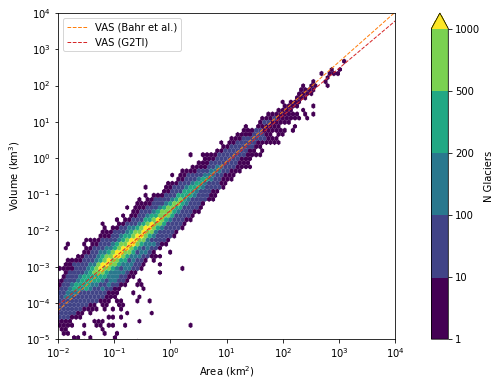

In [102]:
# Cmap norm
norm = ExtendedNorm([1, 10, 100, 200, 500, 1000], ncolors=256, extend='max')
cm = copy.copy(plt.get_cmap('viridis'))
cm.set_under('white')

# Figure and plot
f, ax = plt.subplots(1, 1, figsize=(7, 6))

dfl.plot.hexbin(ax=ax, x="rgi_area_km2", y="composite_vol_km3", norm=norm, cmap=cm, 
                colorbar=False, gridsize=70, linewidths=0.1);

# Fit
xvas = np.array([0.01, 1, 10, 100, 1000, 10000])
vas = 0.034*(xvas**1.375)
fit = np.exp(intercept) * (xvas ** slope)
ax.plot(np.log(xvas), np.log(vas), '--', color='C1', label='VAS (Bahr et al.)', linewidth=1)
ax.plot(np.log(xvas), np.log(fit), '--', color='C3', label='VAS (G2TI)', linewidth=1)

# Manipulate axes
xlim, ylim = [1e-2, 1e4], [1e-5, 1e4]
xlim_exp, ylim_exp = [-2, 4], [-5, 4]
ax.set_xlim(np.log(xlim))
ax.set_ylim(np.log(ylim))

xt = [10.**e for e in np.arange(xlim_exp[0], xlim_exp[1]+1)]
xl = ["10$^{"+"{:d}".format(int(x))+"}$" for x in np.arange(xlim_exp[0], xlim_exp[1]+1)]
ax.set_xticks(np.log(xt))
ax.set_xticklabels(xl)

yt = [10.**e for e in np.arange(ylim_exp[0], ylim_exp[1]+1)]
yl = ["10$^{"+"{:d}".format(int(x))+"}$" for x in np.arange(ylim_exp[0], ylim_exp[1]+1)]
ax.set_yticks(np.log(yt))
ax.set_yticklabels(yl)

# Legend
plt.legend();

ax.set_xlabel('Area (km$^{2}$)')
ax.set_ylabel('Volume (km$^{3}$)')

# Colorbar
cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.5)
ColorbarBase(cax, extend='max', orientation='vertical', cmap=cm, norm=norm, label='N Glaciers');